In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from model import TargetedSentimentEncoder
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
base_model = 'cross-encoder/nli-roberta-base'
model = TargetedSentimentEncoder(base_model=base_model, device=device).to(device)
model.load_state_dict(torch.load('./model/model.pth'))

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of RobertaModel were not initialized from the model checkpoint at cross-encoder/nli-roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably

<All keys matched successfully>

In [4]:
data = load_dataset('fhamborg/news_sentiment_newsmtsc')

# Embedding Space Visualization

In [5]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [6]:
test_dataset = data['test']
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [7]:
model.eval()

query_embeddings = []
sentence_embeddings = []
labels = []

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        # Extract 'mention', 'sentence', and 'polarity' from the batch
        query_text, sentence_text, polarity = batch['mention'], batch['sentence'], batch['polarity']
        
        # Get query and sentence embeddings from the model
        query_embeds, sentence_embeds = model(query_text, sentence_text)
        
        # Move embeddings and labels to CPU and convert to NumPy arrays
        query_embeddings.append(query_embeds.cpu().numpy())
        sentence_embeddings.append(sentence_embeds.cpu().numpy())
        labels.append(polarity.numpy())  # Assuming polarity is a tensor, else keep it as is if already numpy

# Convert the lists of embeddings and labels to NumPy arrays
query_embeddings = np.vstack(query_embeddings)  # Stack the lists into one 2D NumPy array
sentence_embeddings = np.vstack(sentence_embeddings)
labels = np.hstack(labels)  # Flatten the list of labels into a 1D array

100%|██████████| 51/51 [00:02<00:00, 24.08it/s]


In [43]:
from sklearn.metrics.pairwise import cosine_similarity
cos_sim = np.diag(cosine_similarity(query_embeddings, sentence_embeddings))

In [21]:
# Combine and reduce the embeddings using t-SNE
combined_embeddings = np.hstack((query_embeddings, sentence_embeddings))
tsne = TSNE(n_components=2)
reduced_embeddings = tsne.fit_transform(combined_embeddings)

In [10]:
combined_embeddings.shape

(1606, 768)

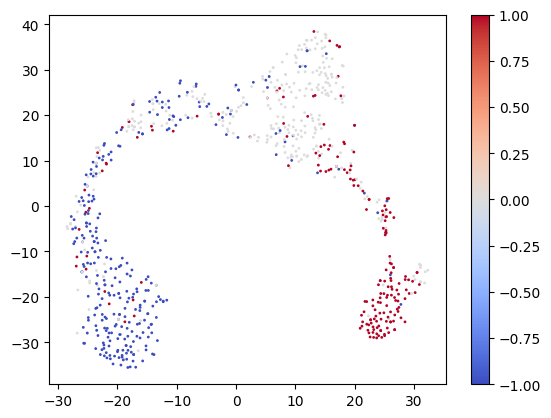

In [22]:
# Plot the embeddings
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='coolwarm', s=1)
plt.colorbar()
plt.show()

# Inspect distribution of cosine similarity across positive, negative and neutral examples

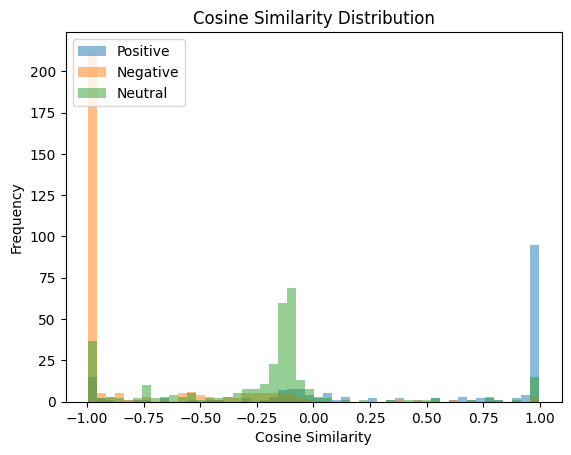

In [44]:
pos_sim = cos_sim[labels == 1]
neg_sim = cos_sim[labels == -1]
neu_sim = cos_sim[labels == 0]

plt.hist(pos_sim, bins=50, alpha=0.5, label='Positive')
plt.hist(neg_sim, bins=50, alpha=0.5, label='Negative')
plt.hist(neu_sim, bins=50, alpha=0.5, label='Neutral')
plt.legend(loc='upper left')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Cosine Similarity Distribution')
plt.show()

# Classification metrics

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [47]:
def map_to_discrete(values, pos_threshold=0.5, neg_threshold=-0.5):
    """
    Map values between -1 and 1 to discrete values: -1, 0, or 1.
    
    Args:
        values (np.ndarray): Array of values between -1 and 1.
        pos_threshold (float): Threshold above which values are considered positive (mapped to 1).
        neg_threshold (float): Threshold below which values are considered negative (mapped to -1).
    
    Returns:
        np.ndarray: Array of discrete values (-1, 0, 1).
    """
    discrete_values = np.zeros_like(values)
    discrete_values[values > pos_threshold] = 1    
    discrete_values[values < neg_threshold] = -1
    return discrete_values

In [48]:
y_pred = map_to_discrete(cos_sim)
y_pred.shape

(803,)

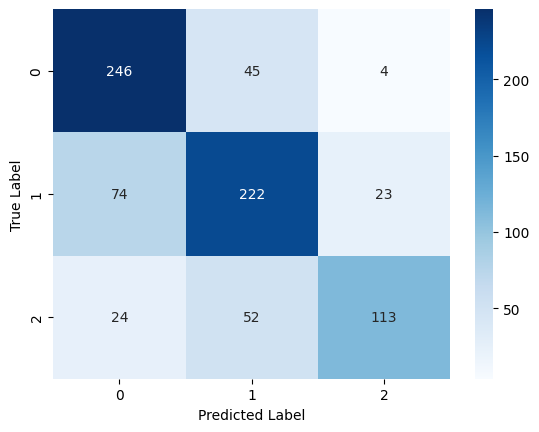

In [53]:
# Assume y_true are the true labels and y_pred are the predicted labels
cm = confusion_matrix(labels, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [54]:
print(classification_report(labels, y_pred))

              precision    recall  f1-score   support

          -1       0.72      0.83      0.77       295
           0       0.70      0.70      0.70       319
           1       0.81      0.60      0.69       189

    accuracy                           0.72       803
   macro avg       0.74      0.71      0.72       803
weighted avg       0.73      0.72      0.72       803



# Retrieval metrics